# Decision Tree Regressor Model

### Import dependencies for data manipulation and visualization

In [90]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


Read in data from pkl file

In [91]:
df = pd.read_pickle('../../data/ava_st1_ns4_56.pkl')
df.head


<bound method NDFrame.head of        apcp_sf1_1  apcp_sf2_1 apcp_sf3_1  apcp_sf4_1  apcp_sf5_1  dlwrf_s1_1  \
V1       0.000000         0.0          1    0.000000    0.000000  256.492673   
V2       0.000000         0.0          1    0.017273    0.139091  257.998596   
V3       0.000000         0.0          1    0.000000    0.000000  219.280002   
V4       0.004545         0.0          1    0.000000    0.000000  267.863045   
V5       0.000000         0.0          1    0.000000    0.000000  238.162747   
...           ...         ...        ...         ...         ...         ...   
V4376    0.010909         0.0          1    0.000000    0.000000  278.168651   
V4377    0.000000         0.0          1    0.000000    0.000000  251.551092   
V4378    0.000000         0.0          1    0.000000    0.000000  269.446164   
V4379    0.000000         0.0          1    0.000000    0.000000  268.862049   
V4380    0.000000         0.0          1    0.000000    0.000000  269.112621   

       dl

Establish input and output columns

In [92]:
x = df.drop('energy', axis=1)
y = df['energy']


Import sklearn dependencies

In [93]:
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_selector
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split


#### Standardize the data and scale it for easier processing.

In [94]:
preprocessor = ColumnTransformer(
    transformers = [
        ('STscaler', StandardScaler(), make_column_selector(dtype_include=np.float64)),
        ('MMscaler', MinMaxScaler(), make_column_selector(dtype_include=np.int64))
    ],
    remainder = 'passthrough'
)

preprocessor.fit(x)

X =  preprocessor.transform(x)



# Holdout Method
#### We will use holdout at first to get a baseline accuracy score and show improvements with cross validation and hyperparameter tuning.

First we will split the data into training and testing sets.

In [95]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)


Importing the Decision Tree Regressor model from sklearn

In [96]:
from sklearn.tree import DecisionTreeRegressor

Now we create the DecisionTreeRegressor model, fit it to the training data and make a prediction on the test data that will be validated in subsequest cells.

In [97]:
tree = DecisionTreeRegressor(max_depth=5)
tree.fit(X_train, y_train)


DecisionTreeRegressor(max_depth=5)

In [98]:
y_pred = tree.predict(X_test)

#### Creating a Dummy regressor to see if the model is better than a trivial model.

In [99]:
from sklearn.dummy import DummyRegressor

In [100]:
dummy_regressor = DummyRegressor(strategy='mean')
dummy_regressor.fit(X_train, y_train)
y_pred_dummy = dummy_regressor.predict(X_test)

### Import dependencies for evaluation metrics and calculate mean squared error, r2 score, mean absolute error.

In [101]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error

my_scores = []


In [102]:
mse_values = ["MSE"]
mse = mean_squared_error(y_test, y_pred)
mse_dummy = mean_squared_error(y_test, y_pred_dummy)
print("The model's mse: ", mse)
print("The dummy's mse: ", mse_dummy)
print("Relative error: ", mse/mse_dummy)

mse_values.append(mse)
mse_values.append(mse_dummy)

my_scores.append(mse_values)




The model's mse:  12991553720442.99
The dummy's mse:  60573816149004.98
Relative error:  0.2144747441449815


In [103]:
r2_values = ["R2"]
r2 = r2_score(y_test, y_pred)
r2_dummy = r2_score(y_test, y_pred_dummy)
print("The model's r2: ", r2)   
print("The dummy's r2: ", r2_dummy)

r2_values.append(r2)
r2_values.append(r2_dummy)

my_scores.append(r2_values)

The model's r2:  0.7854145150554134
The dummy's r2:  -0.00051633491881109


In [104]:
mae_values = ["MAE"]
mae = mean_absolute_error(y_test, y_pred)
mae_dummy = mean_absolute_error(y_test, y_pred_dummy)
print("The model's mae: ", mae)
print("The dummy's mae: ", mae_dummy)
print("Relative error: ", mae/mae_dummy)

mae_values.append(mae)
mae_values.append(mae_dummy)

my_scores.append(mae_values)

The model's mae:  2515147.5864677555
The dummy's mae:  6652955.606117469
Relative error:  0.3780496572312986


#### Now we want to visualize these scores and determine how we'll compare it to other more sophisticated models.

In [105]:
print(f"{'Evaluation method':<25} {'Score':<20} {'Dummy Score':<20} {'Ratio (Score/Dummy Score)':<20}")

for item in my_scores:
    ratio = item[1]/item[2] if item[2] != 0 else 0
    print(f"{item[0]:<25} {item[1]:<20.3f} {item[2]:<20.3f} {ratio:<10.3f}")
    
    # print the ratio of the mse score over the mean value of y_test
print(f"Ratio of mae over mean value of y: {(mae)/np.mean(y):.3f}")

Evaluation method         Score                Dummy Score          Ratio (Score/Dummy Score)
MSE                       12991553720442.990   60573816149004.977   0.214     
R2                        0.785                -0.001               -1521.134 
MAE                       2515147.586          6652955.606          0.378     
Ratio of mae over mean value of y: 0.149


Given the bi-modal distribution of the data, we will need to consider the mean absolute error as the primary evaluation metric.


#### Let's also look at the residuals to see if there are any patterns.

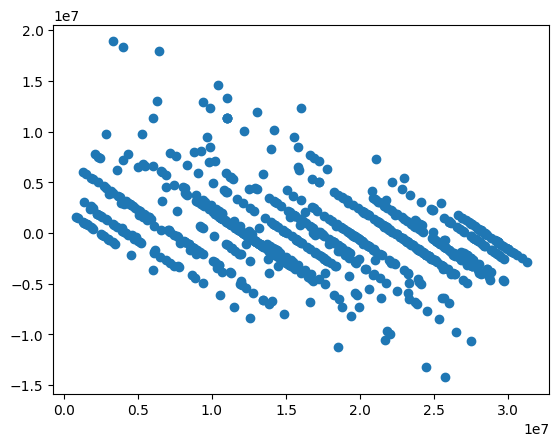

In [106]:
plt.scatter(y_test, y_pred - y_test)
plt.show()

Here, each stripe represents a leaf in the DecisionTreeRegressor. The residuals here appear relatively constant across the range of predicted values. 

# K-Fold Cross Validation

#### Hyper Parameter Tuning with Cross Validation